In [7]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import cv2
import os
import re
import pandas as pd

from src.background_removal import get_mask_and_foreground, evaluate_pixel_mask, evaluate_masks


# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week3')
os.chdir(BASE_PATH)
print(BASE_PATH)


DATA_DIRECTORY = '../data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/projects/master/c1/Team5/week3


In [4]:
def validate_order(list_1: list[str], list_2: list[str]) -> bool:
    assert len(list_1) == len(list_2)

    for i in range(0, len(list_1)):
        if list_1[i].split('.')[0] != list_2[i].split('.')[0]:
            print(i, list_1[i], list_2[i])
            return False
    return True


In [11]:
import platform
from tqdm import tqdm

class Image:
    def __init__(self, path: str):
        self.path = path
        self.index = self._extract_index(path)
        self.original_image = cv2.imread(path)

    def _extract_index(self, file_path):
        os_name = platform.system()

        if os_name == 'Windows':
            file_name = file_path.split('\\\\')[-1]
        else:
            file_name = file_path.split('/')[-1]

        name = file_name.split('.')[0]
        number = name.split('_')[-1]
        return int(number)


class ImageDataset:
    def __init__(
            self,
            directory_path: str,
        ):
        self.directory_path = directory_path
        self.images = self.load_dataset()


    def load_dataset(self):
        # List all images in the directory that have '.jpg' extension
        image_filenames = [f for f in os.listdir(self.directory_path) if f.endswith('.jpg')]
        image_filenames = sorted(image_filenames)
        result = [
            Image(os.path.join(self.directory_path, filename))
            for filename in tqdm(image_filenames)
        ]
        
        return result

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        return self.images[index]



BGDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd1_w4')

background_files = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd1_w4') if f.endswith('.png')]
background_files = sorted(background_files)


assert validate_order(
    [image.path.split('/')[-1].split('.')[0] for image in BGDataset.images],
    [bg_file.split('.')[0] for bg_file in background_files]
    )

100%|██████████| 30/30 [00:00<00:00, 64.35it/s]


/tmp/ipykernel_10288/3665184541.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 4))


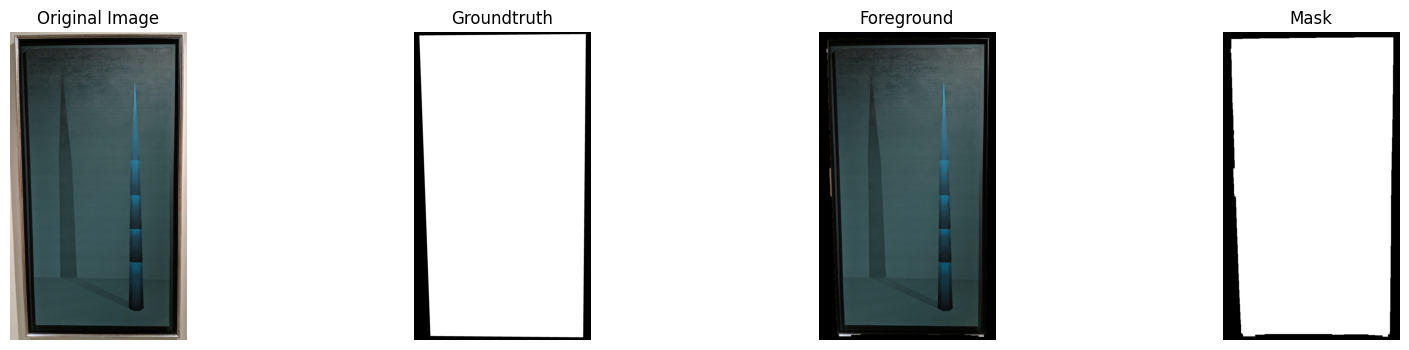

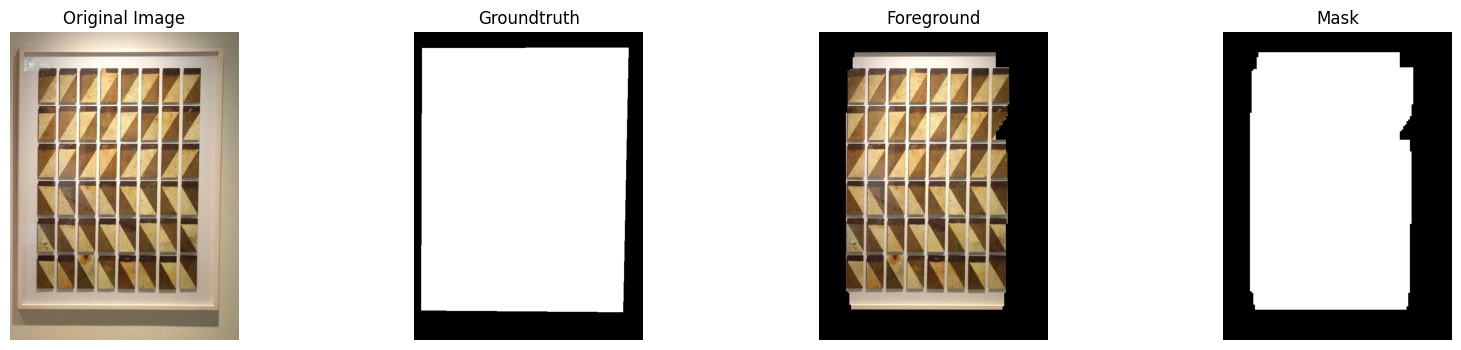

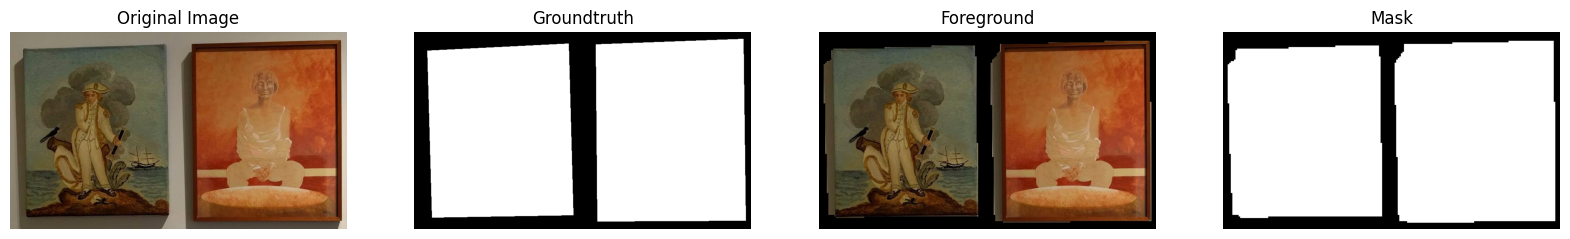

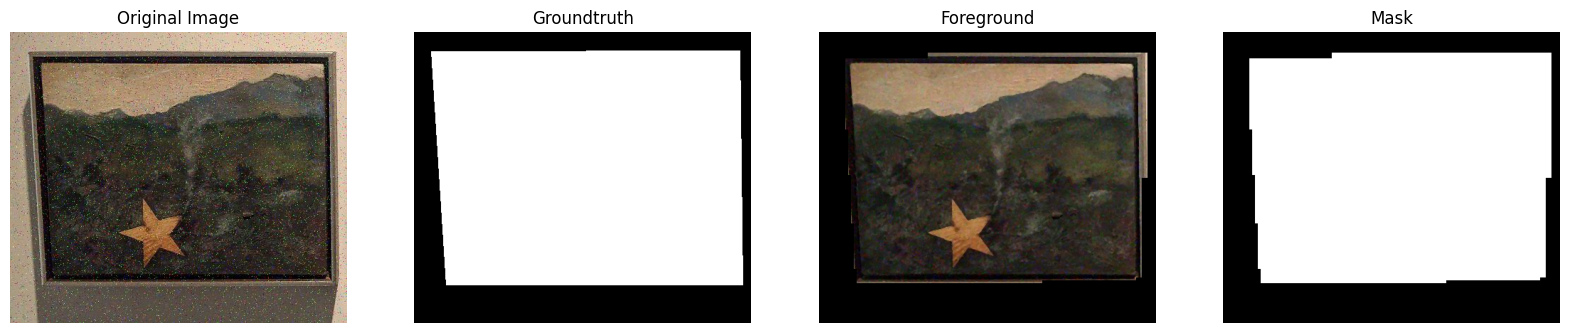

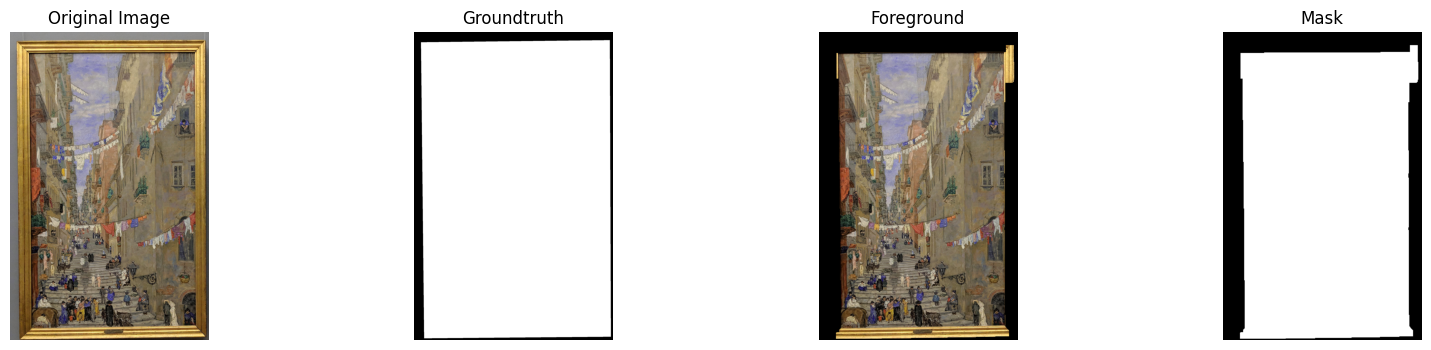

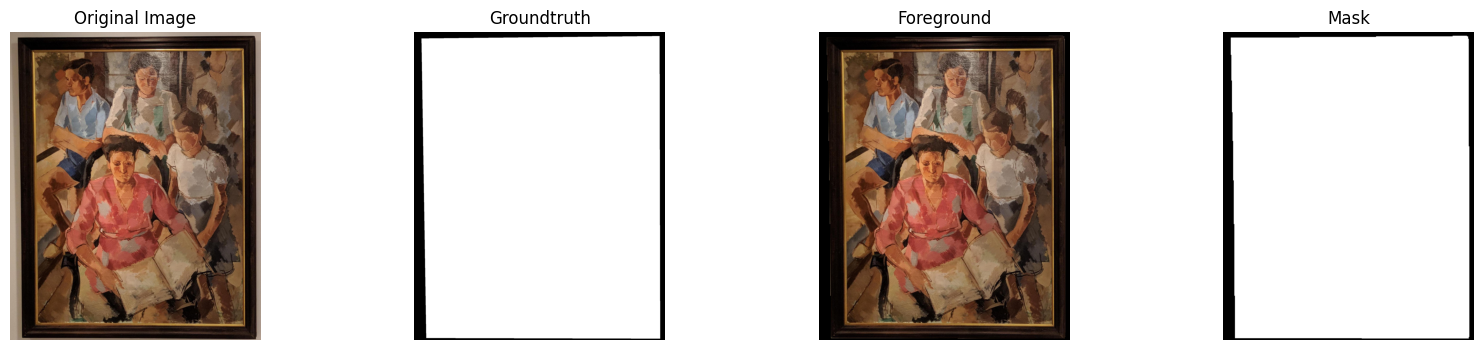

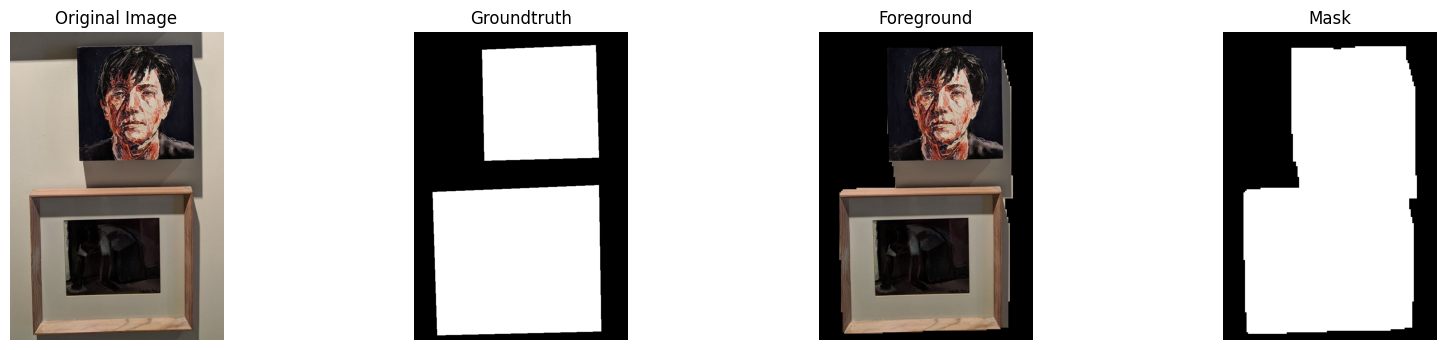

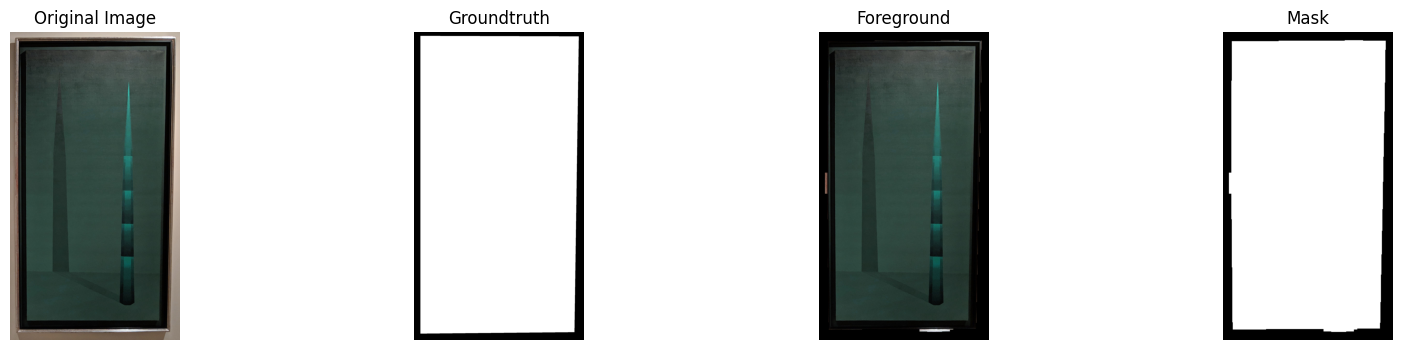

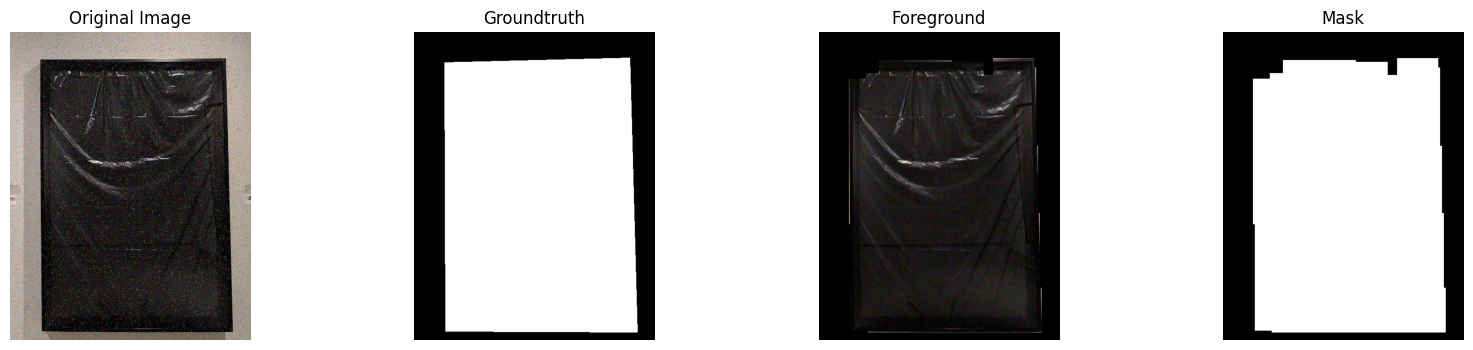

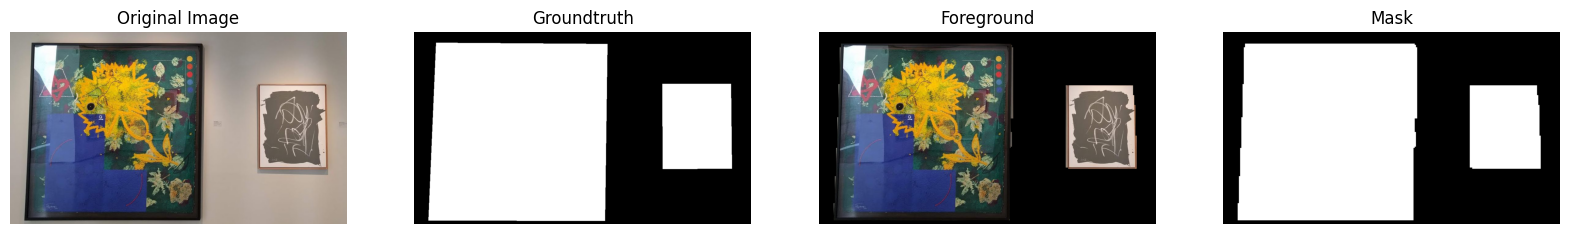

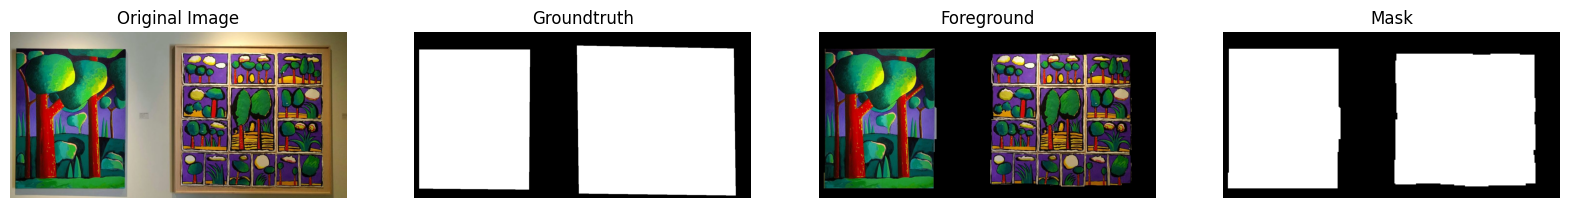

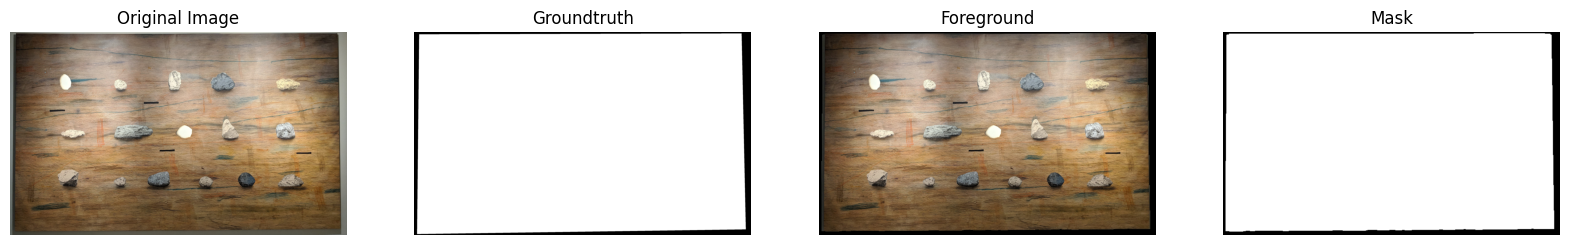

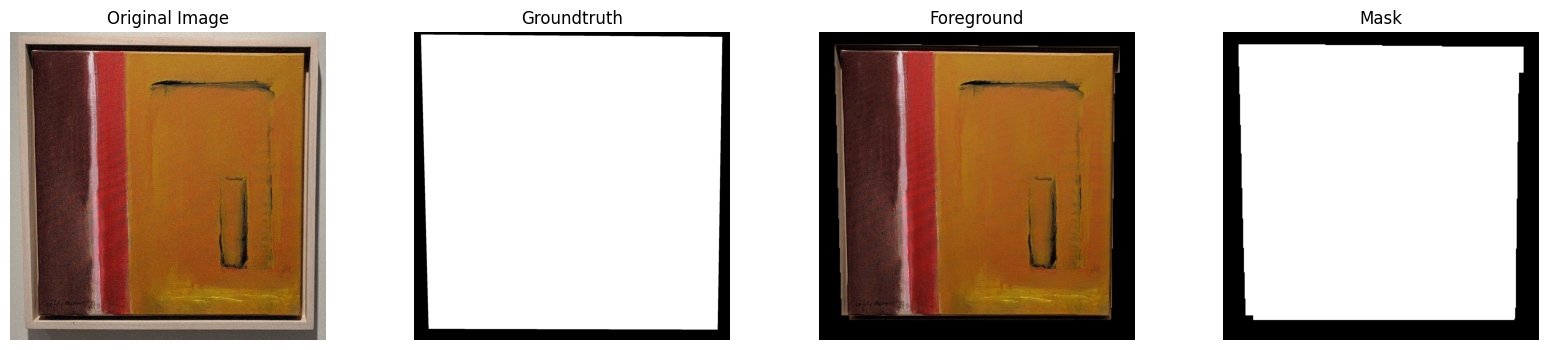

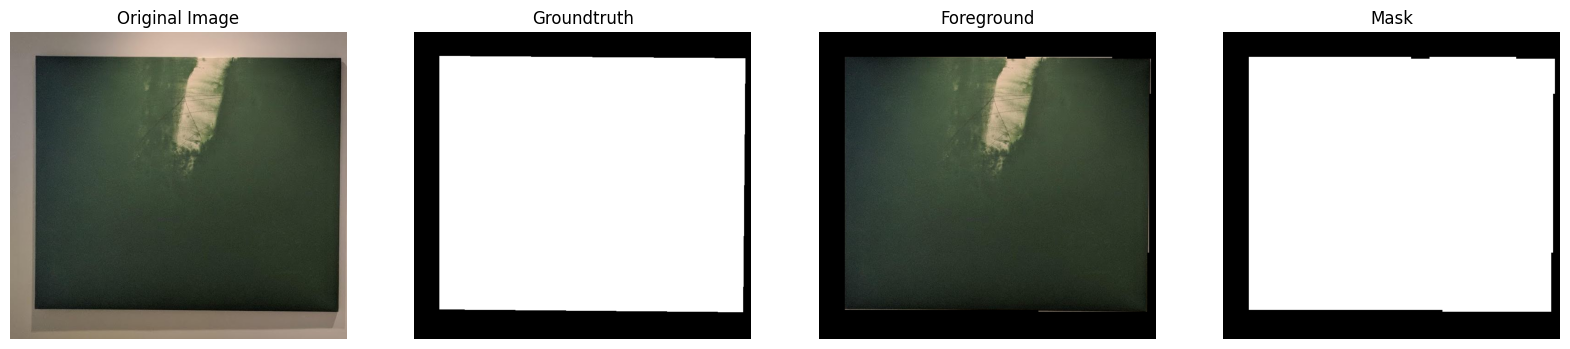

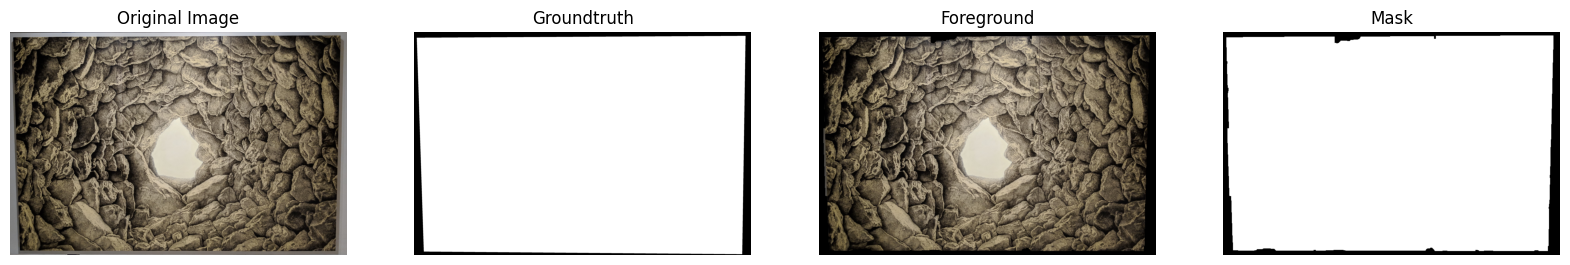

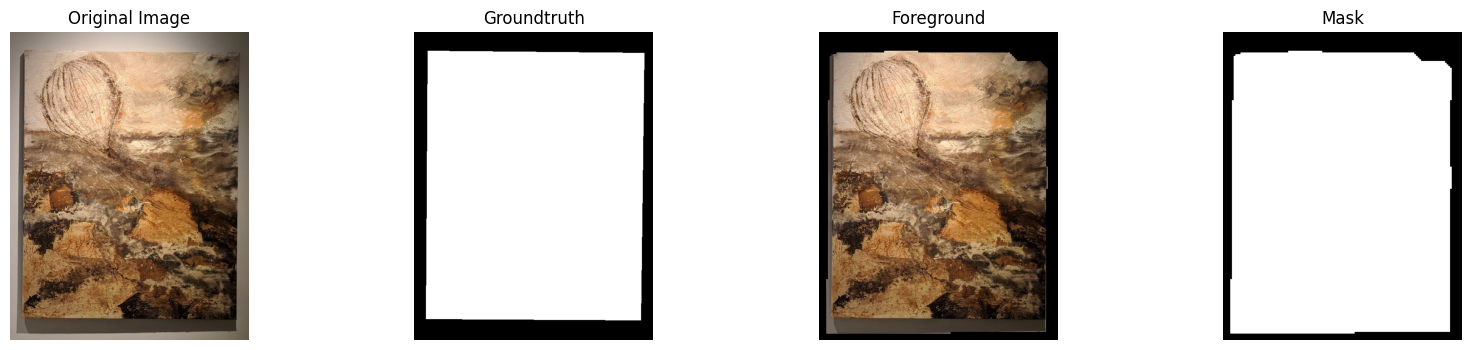

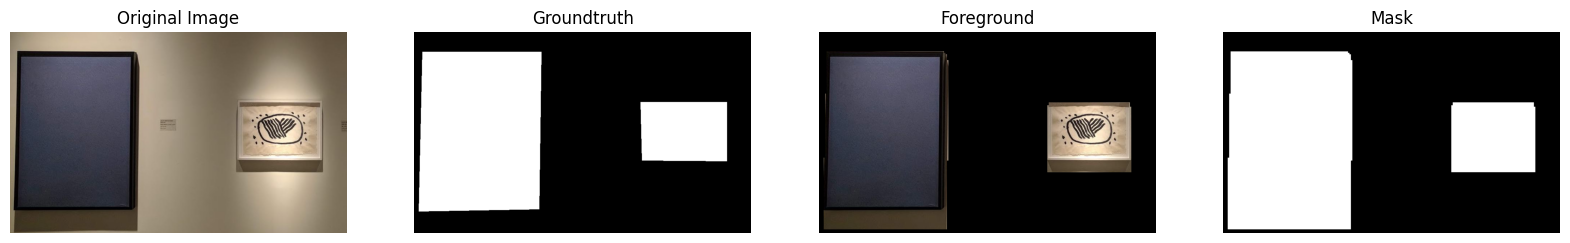

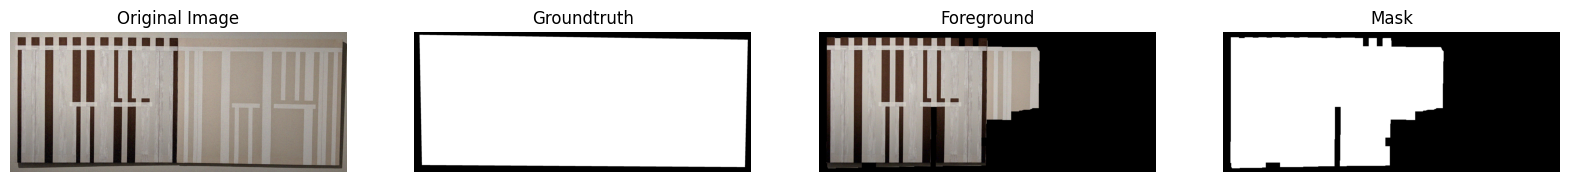

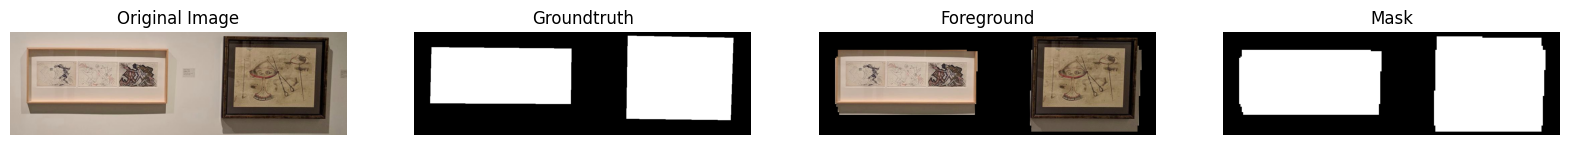

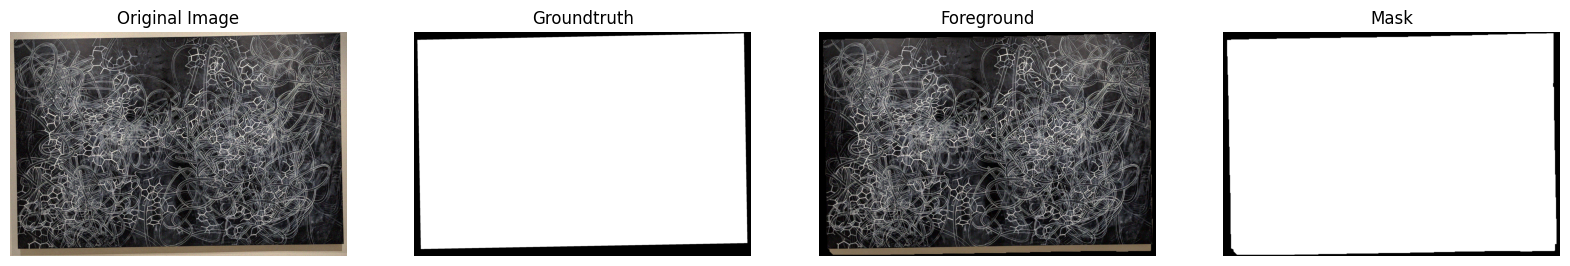

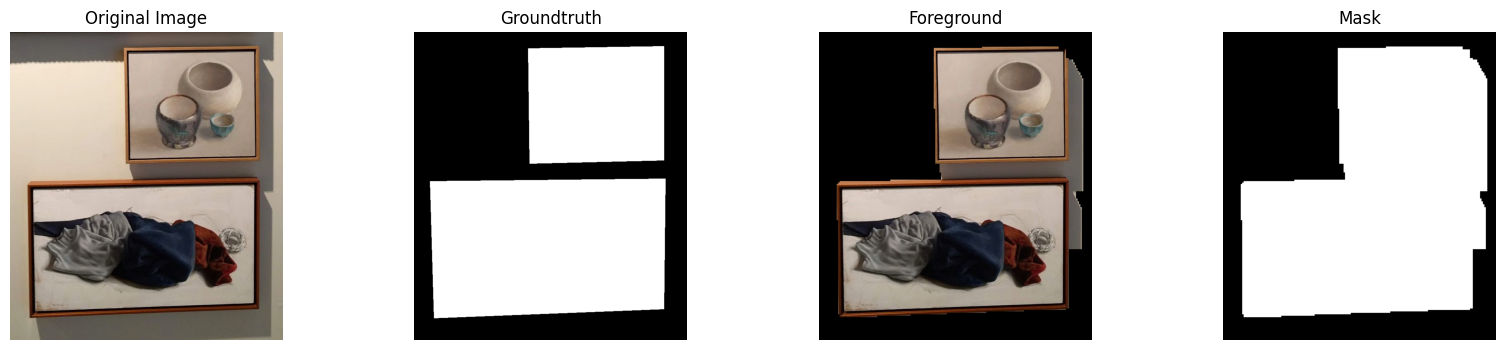

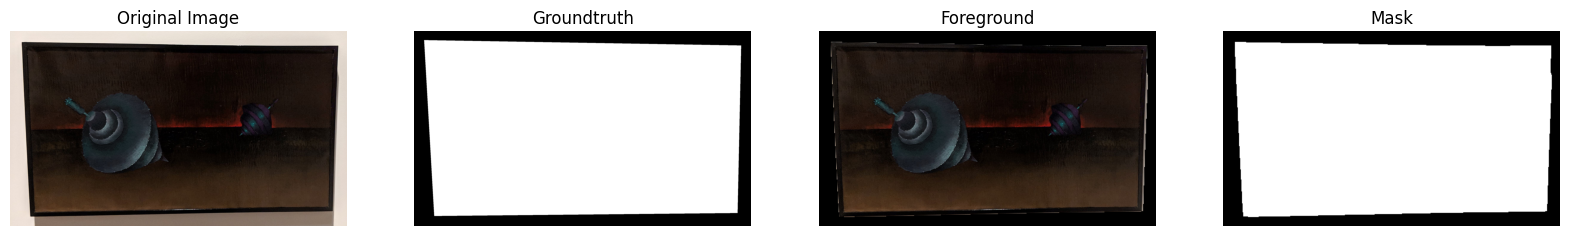

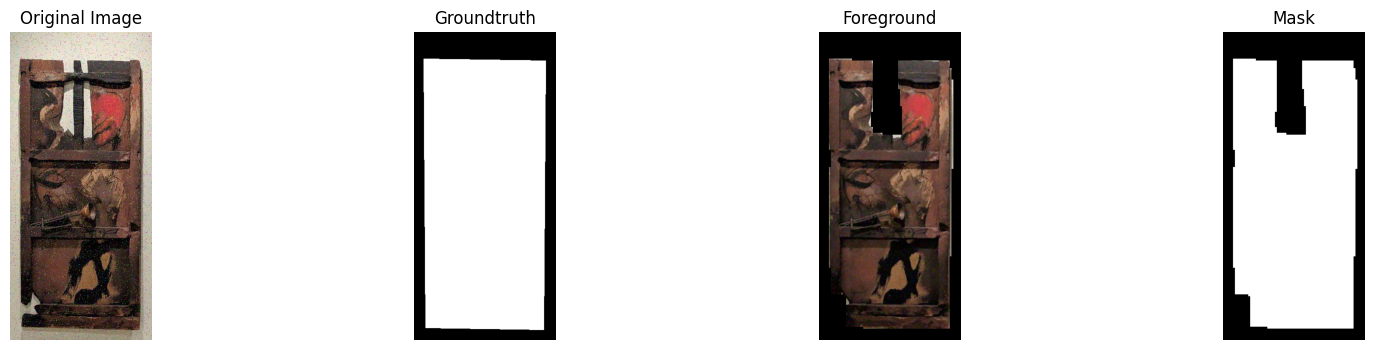

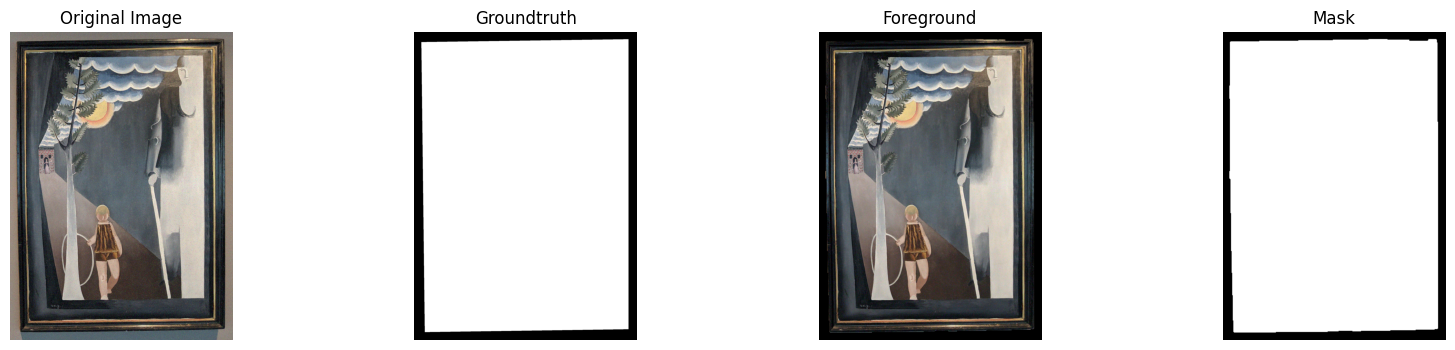

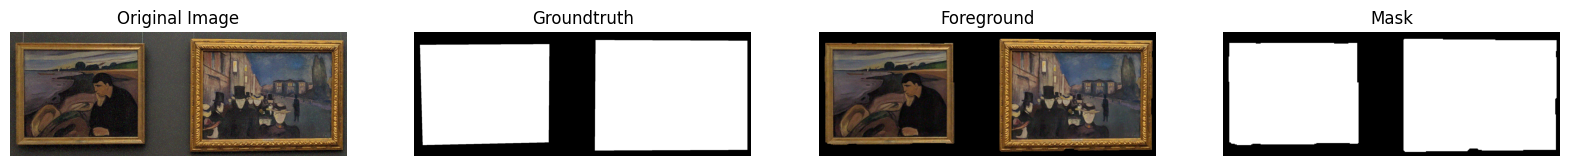

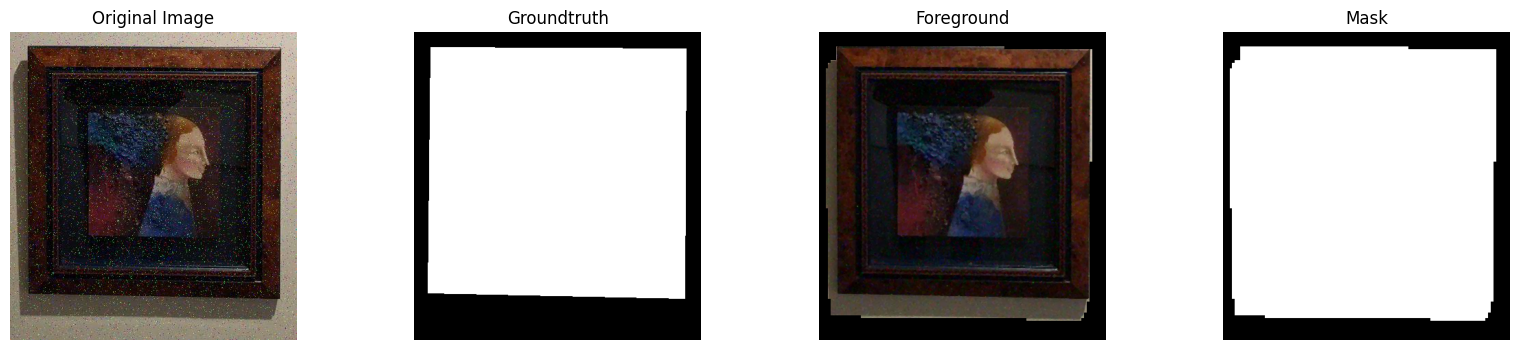

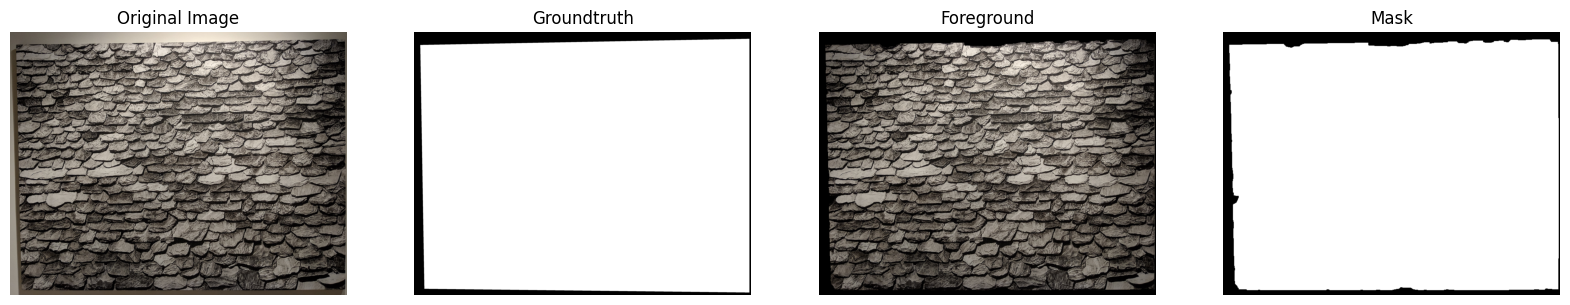

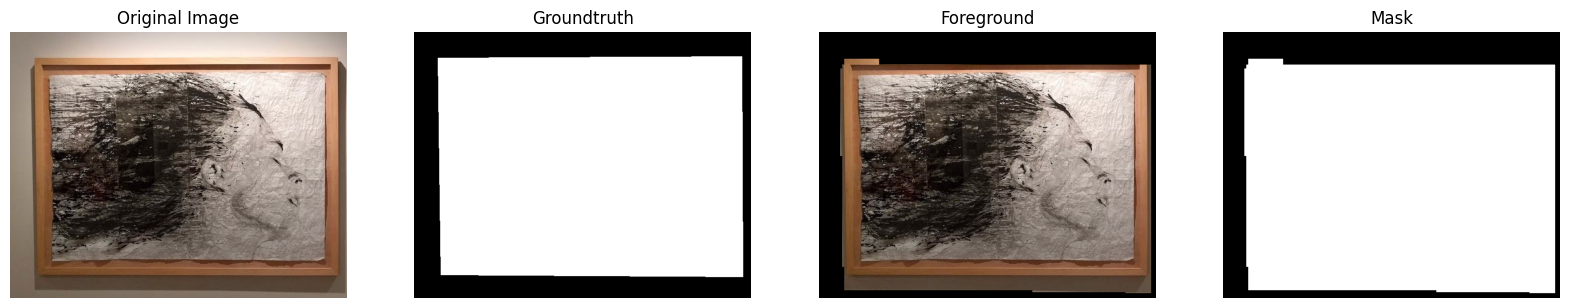

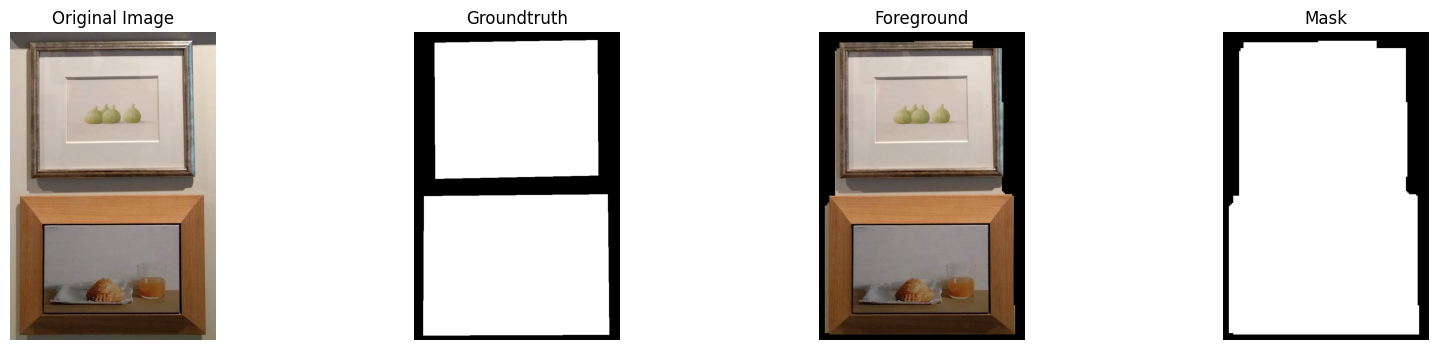

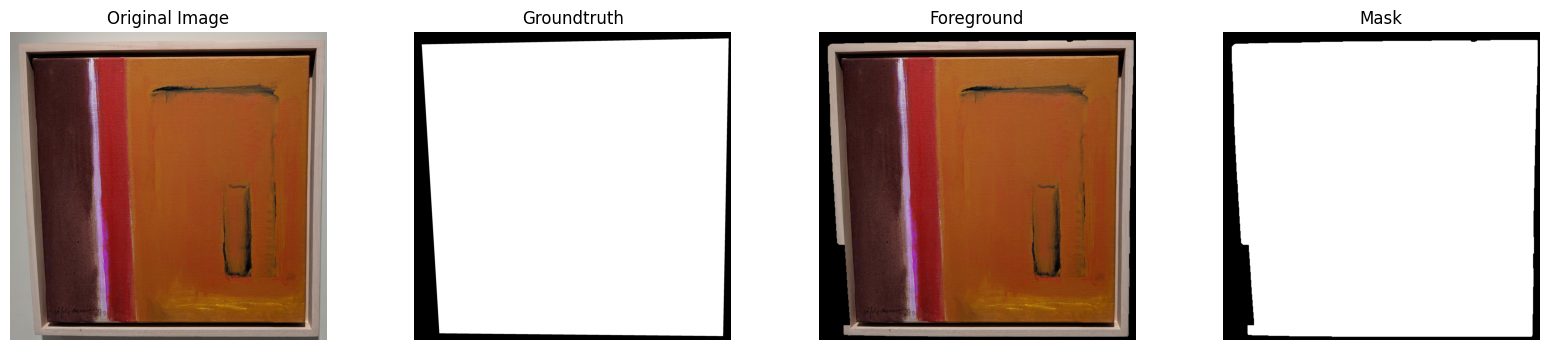

In [12]:
# grabcut_iters: 6 closing: 9 opening: 33

closing = 17
opening = 45
grabcut_iters = 5
# Loop will need to be changed to len(background_files) --> for i in range(0, len(background_files))
image_indexes = list(range(0, 30))
for i in image_indexes:
    image = cv2.cvtColor(BGDataset.images[i].original_image, cv2.COLOR_BGR2RGB)

    # Original Image
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Groundtruth
    ground_truth = os.path.join(f'{DATA_DIRECTORY}/qsd1_w4', background_files[i])
    ground_truth = cv2.imread(ground_truth)
    plt.subplot(1, 4, 2)
    plt.imshow(ground_truth)
    plt.title('Groundtruth')
    plt.axis('off')

    # Get foreground and mask
    foreground, mask = get_mask_and_foreground(image, enhancing_factor=0, th2_method='grabcut', closing_size=closing,
                                               opening_size=opening, adaptative_area=grabcut_iters)
    plt.subplot(1, 4, 3)
    plt.imshow(foreground, cmap='gray')
    plt.title('Foreground')
    plt.axis('off')
    

    plt.subplot(1, 4, 4)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

In [4]:






bg_filenames = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd2_w3') if f.endswith('.jpg')]
bg_filenames.sort()
gt_filenames = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd2_w3') if f.endswith('.png')]
gt_filenames.sort()

validate_order(bg_filenames, gt_filenames)

True

In [5]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.filters import median, gaussian, laplace, prewitt, sobel
from skimage.morphology import disk

from src.background_removal import apply_filter, normalize_image



In [6]:
FOREGROUND_DIR = "data_results/foregrounds"
MASK_DIR = "data_results/masks"
dataset_name = "qsd1_w4"

if not os.path.exists(FOREGROUND_DIR):
    os.makedirs(FOREGROUND_DIR)

if not os.path.exists(MASK_DIR):
    os.makedirs(MASK_DIR)

In [24]:
import pandas as pd

for bg_filename, gt_filename in zip(bg_filenames, gt_filenames):
    bg_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, bg_filename))

    fg, mask = get_mask_and_foreground_w2(bg_image)
    gt = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, gt_filename), cv2.IMREAD_GRAYSCALE)

    # Define paths for saving
    foreground_path = os.path.join(FOREGROUND_DIR, bg_filename)
    mask_path = os.path.join(MASK_DIR, gt_filename)

    # Save the foreground and mask
    cv2.imwrite(foreground_path, cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_path, mask)

precision, recall, f1_score = evaluate_masks(MASK_DIR, os.path.join(DATA_DIRECTORY, dataset_name))
results = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1 Score'],
        'Value': [precision, recall, f1_score]
    })
results

Metric     Value
0  Precision  0.911367
1     Recall  0.872640
2   F1 Score  0.871493

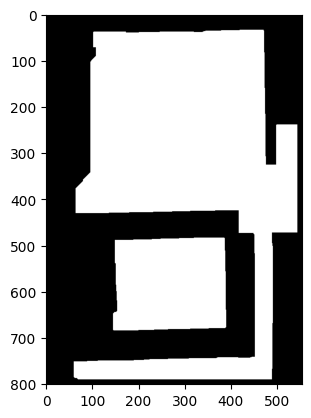

In [51]:
image_code = "00006"
dataset_name = "qsd1_w4"
noisy_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, f'{image_code}.jpg'))
og_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, 'non_augmented',f'{image_code}.jpg'))
gt_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, f'{image_code}.png'), cv2.IMREAD_GRAYSCALE)

# convert images to Gray
# gray_noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)
closing_size = 17
opening_size = 33
grabcut_iters = 5
grabcut_iters_list = [5, 9, 13, 15]
foreground, mask = get_mask_and_foreground(noisy_image, closing_size=closing_size, opening_size=opening_size, enhancing_factor=0,
                                                                grabcut_iters=grabcut_iters, th2_method='grabcut')

    # return foreground, th2, closing_mask, reconstruct, mask
plt.imshow(mask, cmap='gray')

In [ ]:





image_code = "00001"
dataset_name = "qsd1_w4"
noisy_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, f'{image_code}.jpg'))
og_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, 'non_augmented',f'{image_code}.jpg'))
gt_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, f'{image_code}.png'), cv2.IMREAD_GRAYSCALE)

# convert images to Gray
# gray_noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)
closing_size = 5
opening_size = 35
grabcut_iters = 5
grabcut_iters_list = [5, 9, 13, 15]
masks = [get_mask_and_foreground(noisy_image, closing_size=closing_size, opening_size=opening_size, enhancing_factor=2,
                                                                grabcut_iters=iters, th2_method='grabcut') for iters in grabcut_iters_list]

    # return foreground, th2, closing_mask, reconstruct, mask

fig, axs = plt.subplots(1, 4, figsize=(20, 10))

axs[0].imshow(masks[0][1], cmap='gray')
axs[0].set_title(f'th2 - {grabcut_iters}')
axs[0].axis('off')


axs[1].imshow(masks[1][1], cmap='gray')
axs[1].set_title(f'closing - {closing_size}')
axs[1].axis('off')



axs[2].imshow(masks[2][1], cmap='gray')
axs[2].set_title('reconstruct')
axs[2].axis('off')


axs[3].imshow(masks[3][1], cmap='gray')
axs[3].set_title(f'opening - {opening_size}')
axs[3].axis('off')

plt.show()

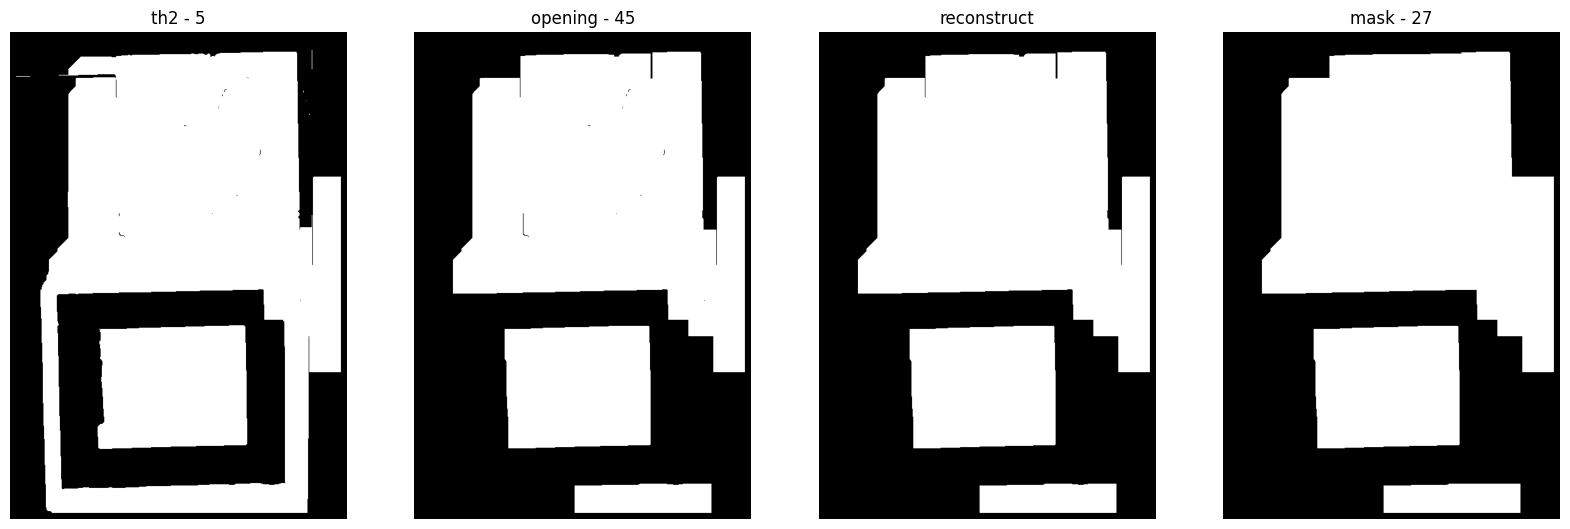

In [10]:





image_code = "00006"
dataset_name = "qsd1_w4"
noisy_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, f'{image_code}.jpg'))
og_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, 'non_augmented',f'{image_code}.jpg'))
gt_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, f'{image_code}.png'), cv2.IMREAD_GRAYSCALE)

# convert images to Gray
# gray_noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)
closing_size = 27
opening_size = 45
iters = 5
# grabcut_iters_list = [5, 9, 13, 15]
fg, th, opening, reconstruct, closing = get_mask_and_foreground(noisy_image, closing_size=closing_size, opening_size=opening_size, enhancing_factor=0,
                                                                grabcut_iters=iters, th2_method='grabcut')

    # return foreground, th2, closing_mask, reconstruct, mask

fig, axs = plt.subplots(1, 4, figsize=(20, 10))

axs[0].imshow(th, cmap='gray')
axs[0].set_title(f'th2 - {iters}')
axs[0].axis('off')


axs[1].imshow(opening, cmap='gray')
axs[1].set_title(f'opening - {opening_size}')
axs[1].axis('off')



axs[2].imshow(reconstruct, cmap='gray')
axs[2].set_title('reconstruct')
axs[2].axis('off')


axs[3].imshow(closing, cmap='gray')
axs[3].set_title(f'mask - {closing_size}')
axs[3].axis('off')

plt.show()

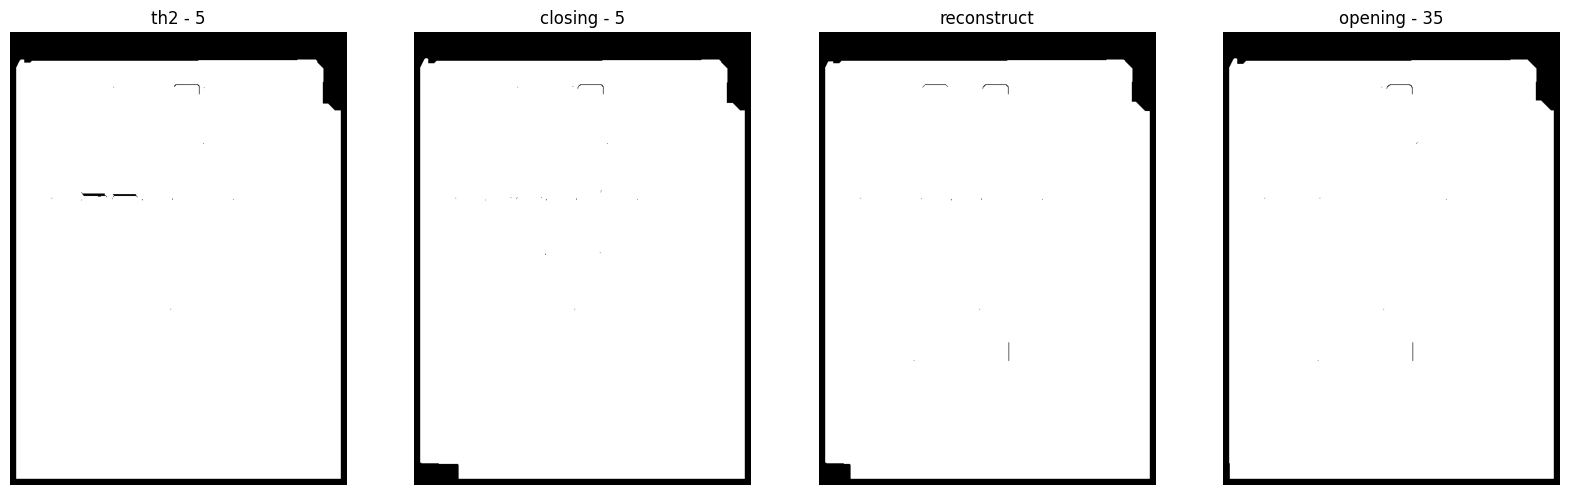

In [27]:
image_code = "00001"
dataset_name = "qsd1_w4"
noisy_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, f'{image_code}.jpg'))
og_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, 'non_augmented',f'{image_code}.jpg'))
gt_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, f'{image_code}.png'), cv2.IMREAD_GRAYSCALE)

# convert images to Gray
# gray_noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)
closing_size = 5
opening_size = 35
grabcut_iters = 5
grabcut_iters_list = [5, 9, 13, 15]
masks = [get_mask_and_foreground(noisy_image, closing_size=closing_size, opening_size=opening_size, enhancing_factor=0,
                                                                grabcut_iters=iters, th2_method='grabcut') for iters in grabcut_iters_list]

    # return foreground, th2, closing_mask, reconstruct, mask

fig, axs = plt.subplots(1, 4, figsize=(20, 10))

axs[0].imshow(masks[0][1], cmap='gray')
axs[0].set_title(f'th2 - {grabcut_iters}')
axs[0].axis('off')


axs[1].imshow(masks[1][1], cmap='gray')
axs[1].set_title(f'closing - {closing_size}')
axs[1].axis('off')



axs[2].imshow(masks[2][1], cmap='gray')
axs[2].set_title('reconstruct')
axs[2].axis('off')


axs[3].imshow(masks[3][1], cmap='gray')
axs[3].set_title(f'opening - {opening_size}')
axs[3].axis('off')

plt.show()

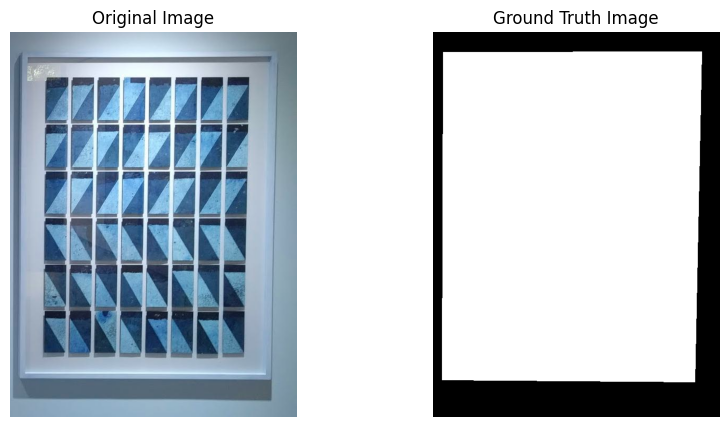

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axs[0].imshow(og_image)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Ground Truth Image
axs[1].imshow(gt_image, cmap='gray')
axs[1].set_title('Ground Truth Image')
axs[1].axis('off')

plt.show()


In [29]:
_, w2 = get_mask_and_foreground_w2(noisy_image)
_, w3 = get_mask_and_foreground(noisy_image)

# Plot the results
plt.figure(figsize=(10, 7))

# Original Noisy Image
plt.subplot(2, 2, 1)
plt.imshow(w2, cmap='gray')
plt.title('Previous week otsu (Grayscale)')
plt.axis('off')

# Magnitude Spectrum of Noisy Image

# Original Image
plt.subplot(2, 2, 2)
plt.imshow(w3, cmap='gray')
plt.title('Current week otsu (Grayscale)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(gray_noisy_image, cmap='gray')
plt.title('Original Noisy Image')
plt.axis('off')

# Original Image
plt.subplot(2, 2, 4)
plt.imshow(gt_image, cmap='gray')
plt.title('Mask Ground Truth')
plt.axis('off')
plt.tight_layout()

plt.show()

ValueError: too many values to unpack (expected 2)

In [61]:

plt.close()

In [62]:






import numpy as np
def normalize_image(image: np.ndarray) -> np.ndarray:
    """
    Normalize the input image to the range [0, 255].

    Parameters:
    image (np.ndarray): Input image to be normalized.

    Returns:
    np.ndarray: Normalized image.
    """
    image_min = image.min()
    image_max = image.max()

    # Shift and scale normalization
    normalized_image = (image - image_min) / (image_max - image_min) * 255

    return normalized_image


# normalized_filtered_image = normalize_image(filtered_noisy_image)
# plt.imshow(normalize_image(apply_filter(noisy_image, 'median')+normalized_filtered_image*5), cmap='gray')

In [10]:
closing = 17
opening = 47
grabcut_iters = 5
for bg_filename, gt_filename in zip(bg_filenames, gt_filenames):
    bg_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, bg_filename))

    foreground, mask = get_mask_and_foreground(bg_image, enhancing_factor=0, th2_method='grabcut', closing_size=closing,
                                               opening_size=opening, adaptative_area=grabcut_iters)
    gt = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, gt_filename), cv2.IMREAD_GRAYSCALE)

    # Define paths for saving
    foreground_path = os.path.join(FOREGROUND_DIR, bg_filename)
    mask_path = os.path.join(MASK_DIR, gt_filename)

    # Save the foreground and mask
    cv2.imwrite(foreground_path, cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_path, mask)

precision, recall, f1_score = evaluate_masks(MASK_DIR, os.path.join(DATA_DIRECTORY, dataset_name))
results = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1 Score'],
        'Value': [precision, recall, f1_score]
    })



In [11]:
results

Metric     Value
0  Precision  0.929197
1     Recall  0.930026
2   F1 Score  0.922309

In [71]:
from tqdm import tqdm


factor = 0
equalize = False
closing = 5
opening = 35
adaptative_area = 11
for bg_filename, gt_filename in zip(bg_filenames, gt_filenames):
    bg_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, bg_filename))

    fg, mask = get_mask_and_foreground(bg_image, enhancing_factor=0, th2_method='adaptative', equalize=True,
                                                    closing_size=closing, opening_size=opening, adaptative_area=adaptative_area)
    gt = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, gt_filename), cv2.IMREAD_GRAYSCALE)

    # Define paths for saving
    foreground_path = os.path.join(FOREGROUND_DIR, bg_filename)
    mask_path = os.path.join(MASK_DIR, gt_filename)

    # Save the foreground and mask
    cv2.imwrite(foreground_path, cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_path, mask)

precision, recall, f1_score = evaluate_masks(MASK_DIR, os.path.join(DATA_DIRECTORY, dataset_name))
results = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1 Score'],
        'Value': [precision, recall, f1_score]
    })
print(results, f'factor: {factor}', f'equalize: {equalize}')
print()

      Metric     Value
0  Precision  0.946419
1     Recall  0.957416
2   F1 Score  0.948266 factor: 0 equalize: False



In [31]:
from tqdm import tqdm


factor = 0
equalize = False
closing = 13
opening = 41
grabcut_iters = 5
for bg_filename, gt_filename in zip(bg_filenames, gt_filenames):
    bg_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, bg_filename))

    fg, mask = get_mask_and_foreground(bg_image, enhancing_factor=0, th2_method='grabcut', equalize=True,
                                                    closing_size=closing, opening_size=opening, grabcut_iters=grabcut_iters)
    gt = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, gt_filename), cv2.IMREAD_GRAYSCALE)

    # Define paths for saving
    foreground_path = os.path.join(FOREGROUND_DIR, bg_filename)
    mask_path = os.path.join(MASK_DIR, gt_filename)

    # Save the foreground and mask
    cv2.imwrite(foreground_path, cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_path, mask)

precision, recall, f1_score = evaluate_masks(MASK_DIR, os.path.join(DATA_DIRECTORY, dataset_name))
results = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1 Score'],
        'Value': [precision, recall, f1_score]
    })
print(results, f'factor: {factor}', f'equalize: {equalize}')
print()

      Metric     Value
0  Precision  0.917274
1     Recall  0.942801
2   F1 Score  0.925601 factor: 0 equalize: False



In [ ]:
assert False

In [32]:
#slightly smaller adaptative areas work better

from tqdm import tqdm

result_list_eq = []
metrics_list_eq = []
closing_sizes = [2**2+1, 2**3+1, 2**4+1, 2**5+1]
opening_sizes = [2**4+1, 2**5+1, 2**6+1]
grabcut_iters_list = [5, 6]
edge_list = [0]


factor = 0

num_closing_sizes = len(closing_sizes)
num_opening_sizes = len(opening_sizes)
num_grabcut = len(grabcut_iters_list)
num_edges = len(edge_list)

total_combinations =  num_closing_sizes * num_opening_sizes * num_grabcut * num_edges
print(f'Total combinations: {total_combinations}')
for grabcut_iters in tqdm(grabcut_iters_list):
    for closing in closing_sizes:
        for opening in opening_sizes:
            for edge in edge_list:
                for bg_filename, gt_filename in zip(bg_filenames, gt_filenames):
                    bg_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, bg_filename))

                    fg, mask = get_mask_and_foreground(bg_image, enhancing_factor=edge, th2_method='grabcut', equalize=True,
                                                        closing_size=closing, opening_size=opening, grabcut_iters=grabcut_iters)
                    gt = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, gt_filename), cv2.IMREAD_GRAYSCALE)

                    # Define paths for saving
                    foreground_path = os.path.join(FOREGROUND_DIR, bg_filename)
                    mask_path = os.path.join(MASK_DIR, gt_filename)

                    # Save the foreground and mask
                    cv2.imwrite(foreground_path, cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR))
                    cv2.imwrite(mask_path, mask)

                precision, recall, f1_score = evaluate_masks(MASK_DIR, os.path.join(DATA_DIRECTORY, dataset_name))
                results = pd.DataFrame({
                        'Metric': ['Precision', 'Recall', 'F1 Score'],
                        'Value': [precision, recall, f1_score]
                    })
                metrics_list_eq.append((precision, recall, f1_score))
                result_list_eq.append((grabcut_iters, closing, opening, edge))
                print(results, f'grabcut_iters: {grabcut_iters}', f'closing: {closing}', f'opening: {opening}')
                print()

Total combinations: 24


  0%|          | 0/2 [00:00<?, ?it/s]

      Metric     Value
0  Precision  0.925970
1     Recall  0.971049
2   F1 Score  0.945985 grabcut_iters: 5 closing: 5 opening: 17

      Metric     Value
0  Precision  0.918650
1     Recall  0.956997
2   F1 Score  0.933912 grabcut_iters: 5 closing: 5 opening: 33

      Metric     Value
0  Precision  0.926972
1     Recall  0.915737
2   F1 Score  0.915223 grabcut_iters: 5 closing: 5 opening: 65

      Metric     Value
0  Precision  0.926721
1     Recall  0.975956
2   F1 Score  0.948841 grabcut_iters: 5 closing: 9 opening: 17

      Metric     Value
0  Precision  0.926589
1     Recall  0.952641
2   F1 Score  0.937294 grabcut_iters: 5 closing: 9 opening: 33

      Metric     Value
0  Precision  0.925938
1     Recall  0.917275
2   F1 Score  0.916403 grabcut_iters: 5 closing: 9 opening: 65

      Metric     Value
0  Precision  0.928338
1     Recall  0.975016
2   F1 Score  0.949201 grabcut_iters: 5 closing: 17 opening: 17

      Metric     Value
0  Precision  0.915151
1     Recall  0.961499

 50%|█████     | 1/2 [1:34:17<1:34:17, 5657.18s/it]

      Metric     Value
0  Precision  0.925159
1     Recall  0.935888
2   F1 Score  0.925811 grabcut_iters: 5 closing: 33 opening: 65

      Metric     Value
0  Precision  0.913739
1     Recall  0.964321
2   F1 Score  0.933484 grabcut_iters: 6 closing: 5 opening: 17

      Metric     Value
0  Precision  0.915861
1     Recall  0.957026
2   F1 Score  0.931503 grabcut_iters: 6 closing: 5 opening: 33

      Metric     Value
0  Precision  0.923630
1     Recall  0.905761
2   F1 Score  0.908433 grabcut_iters: 6 closing: 5 opening: 65

      Metric     Value
0  Precision  0.915941
1     Recall  0.967586
2   F1 Score  0.936282 grabcut_iters: 6 closing: 9 opening: 17

      Metric     Value
0  Precision  0.929012
1     Recall  0.959524
2   F1 Score  0.941029 grabcut_iters: 6 closing: 9 opening: 33

      Metric     Value
0  Precision  0.923407
1     Recall  0.906324
2   F1 Score  0.909136 grabcut_iters: 6 closing: 9 opening: 65

      Metric     Value
0  Precision  0.917928
1     Recall  0.972750

100%|██████████| 2/2 [3:26:10<00:00, 6185.18s/it]  

      Metric     Value
0  Precision  0.913511
1     Recall  0.915506
2   F1 Score  0.906961 grabcut_iters: 6 closing: 33 opening: 65



In [ ]:
data_grabcut = """
Total combinations: 24
  0%|          | 0/2 [00:00<?, ?it/s]
      Metric     Value
0  Precision  0.925970
1     Recall  0.971049
2   F1 Score  0.945985 grabcut_iters: 5 closing: 5 opening: 17

      Metric     Value
0  Precision  0.918650
1     Recall  0.956997
2   F1 Score  0.933912 grabcut_iters: 5 closing: 5 opening: 33

      Metric     Value
0  Precision  0.926972
1     Recall  0.915737
2   F1 Score  0.915223 grabcut_iters: 5 closing: 5 opening: 65

      Metric     Value
0  Precision  0.926721
1     Recall  0.975956
2   F1 Score  0.948841 grabcut_iters: 5 closing: 9 opening: 17

      Metric     Value
0  Precision  0.926589
1     Recall  0.952641
2   F1 Score  0.937294 grabcut_iters: 5 closing: 9 opening: 33

      Metric     Value
0  Precision  0.925938
1     Recall  0.917275
2   F1 Score  0.916403 grabcut_iters: 5 closing: 9 opening: 65

      Metric     Value
0  Precision  0.928338
1     Recall  0.975016
2   F1 Score  0.949201 grabcut_iters: 5 closing: 17 opening: 17

      Metric     Value
0  Precision  0.915151
1     Recall  0.961499
2   F1 Score  0.933473 grabcut_iters: 5 closing: 17 opening: 33

      Metric     Value
0  Precision  0.912672
1     Recall  0.919526
2   F1 Score  0.909812 grabcut_iters: 5 closing: 17 opening: 65

      Metric     Value
0  Precision  0.925736
1     Recall  0.975656
2   F1 Score  0.948072 grabcut_iters: 5 closing: 33 opening: 17

      Metric     Value
0  Precision  0.910570
1     Recall  0.962141
2   F1 Score  0.930796 grabcut_iters: 5 closing: 33 opening: 33

 50%|█████     | 1/2 [1:34:17<1:34:17, 5657.18s/it]
      Metric     Value
0  Precision  0.925159
1     Recall  0.935888
2   F1 Score  0.925811 grabcut_iters: 5 closing: 33 opening: 65

      Metric     Value
0  Precision  0.913739
1     Recall  0.964321
2   F1 Score  0.933484 grabcut_iters: 6 closing: 5 opening: 17

      Metric     Value
0  Precision  0.915861
1     Recall  0.957026
2   F1 Score  0.931503 grabcut_iters: 6 closing: 5 opening: 33

      Metric     Value
0  Precision  0.923630
1     Recall  0.905761
2   F1 Score  0.908433 grabcut_iters: 6 closing: 5 opening: 65

      Metric     Value
0  Precision  0.915941
1     Recall  0.967586
2   F1 Score  0.936282 grabcut_iters: 6 closing: 9 opening: 17

      Metric     Value
0  Precision  0.929012
1     Recall  0.959524
2   F1 Score  0.941029 grabcut_iters: 6 closing: 9 opening: 33

      Metric     Value
0  Precision  0.923407
1     Recall  0.906324
2   F1 Score  0.909136 grabcut_iters: 6 closing: 9 opening: 65

      Metric     Value
0  Precision  0.917928
1     Recall  0.972750
2   F1 Score  0.941189 grabcut_iters: 6 closing: 17 opening: 17

      Metric     Value
0  Precision  0.928464
1     Recall  0.958548
2   F1 Score  0.940266 grabcut_iters: 6 closing: 17 opening: 33

      Metric     Value
0  Precision  0.923716
1     Recall  0.905192
2   F1 Score  0.908305 grabcut_iters: 6 closing: 17 opening: 65

      Metric     Value
0  Precision  0.926938
1     Recall  0.972456
2   F1 Score  0.947013 grabcut_iters: 6 closing: 33 opening: 17

      Metric     Value
0  Precision  0.926760
1     Recall  0.962070
2   F1 Score  0.941321 grabcut_iters: 6 closing: 33 opening: 33

100%|██████████| 2/2 [3:26:10<00:00, 6185.18s/it]  
      Metric     Value
0  Precision  0.913511
1     Recall  0.915506
2   F1 Score  0.906961 grabcut_iters: 6 closing: 33 opening: 65
"""

In [69]:
import pandas as pd
import re

data = """
      Metric     Value
0  Precision  0.947363
1     Recall  0.760340
2   F1 Score  0.818576 adaptative_area: 9 closing: 3 opening: 5

      Metric     Value
0  Precision  0.960389
1     Recall  0.721151
2   F1 Score  0.785258 adaptative_area: 9 closing: 3 opening: 9

      Metric     Value
0  Precision  0.964817
1     Recall  0.697806
2   F1 Score  0.761928 adaptative_area: 9 closing: 3 opening: 17

      Metric     Value
0  Precision  0.934173
1     Recall  0.679156
2   F1 Score  0.743685 adaptative_area: 9 closing: 3 opening: 33

      Metric     Value
0  Precision  0.904658
1     Recall  0.651465
2   F1 Score  0.709688 adaptative_area: 9 closing: 3 opening: 65

      Metric     Value
0  Precision  0.921587
1     Recall  0.966160
2   F1 Score  0.940860 adaptative_area: 9 closing: 5 opening: 5

      Metric     Value
0  Precision  0.928896
1     Recall  0.963795
2   F1 Score  0.943453 adaptative_area: 9 closing: 5 opening: 9

      Metric     Value
0  Precision  0.934996
1     Recall  0.960458
2   F1 Score  0.944774 adaptative_area: 9 closing: 5 opening: 17

      Metric     Value
0  Precision  0.939387
1     Recall  0.956592
2   F1 Score  0.944717 adaptative_area: 9 closing: 5 opening: 33

      Metric     Value
0  Precision  0.929073
1     Recall  0.937174
2   F1 Score  0.924133 adaptative_area: 9 closing: 5 opening: 65

      Metric     Value
0  Precision  0.879868
1     Recall  0.995103
2   F1 Score  0.931339 adaptative_area: 9 closing: 9 opening: 5

      Metric     Value
0  Precision  0.882878
1     Recall  0.994974
2   F1 Score  0.933079 adaptative_area: 9 closing: 9 opening: 9

      Metric     Value
0  Precision  0.887673
1     Recall  0.994733
2   F1 Score  0.935830 adaptative_area: 9 closing: 9 opening: 17

      Metric     Value
0  Precision  0.892891
1     Recall  0.994488
2   F1 Score  0.938792 adaptative_area: 9 closing: 9 opening: 33

      Metric     Value
0  Precision  0.897443
1     Recall  0.994104
2   F1 Score  0.941290 adaptative_area: 9 closing: 9 opening: 65

      Metric     Value
0  Precision  0.847141
1     Recall  0.998085
2   F1 Score  0.911802 adaptative_area: 9 closing: 17 opening: 5

      Metric     Value
0  Precision  0.847871
1     Recall  0.998063
2   F1 Score  0.912270 adaptative_area: 9 closing: 17 opening: 9

      Metric     Value
0  Precision  0.849402
1     Recall  0.998011
2   F1 Score  0.913288 adaptative_area: 9 closing: 17 opening: 17

      Metric     Value
0  Precision  0.852876
1     Recall  0.997811
2   F1 Score  0.915468 adaptative_area: 9 closing: 17 opening: 33

      Metric     Value
0  Precision  0.857862
1     Recall  0.997618
2   F1 Score  0.918618 adaptative_area: 9 closing: 17 opening: 65

      Metric     Value
0  Precision  0.942451
1     Recall  0.804589
2   F1 Score  0.852230 adaptative_area: 11 closing: 3 opening: 5

      Metric     Value
0  Precision  0.958448
1     Recall  0.766392
2   F1 Score  0.824631 adaptative_area: 11 closing: 3 opening: 9

      Metric     Value
0  Precision  0.963767
1     Recall  0.744940
2   F1 Score  0.805954 adaptative_area: 11 closing: 3 opening: 17

      Metric     Value
0  Precision  0.933029
1     Recall  0.727184
2   F1 Score  0.789252 adaptative_area: 11 closing: 3 opening: 33

      Metric     Value
0  Precision  0.904461
1     Recall  0.700581
2   F1 Score  0.757281 adaptative_area: 11 closing: 3 opening: 65

      Metric     Value
0  Precision  0.926457
1     Recall  0.956198
2   F1 Score  0.938487 adaptative_area: 11 closing: 5 opening: 5

      Metric     Value
0  Precision  0.936574
1     Recall  0.952396
2   F1 Score  0.941680 adaptative_area: 11 closing: 5 opening: 9

      Metric     Value
0  Precision  0.945093
1     Recall  0.947580
2   F1 Score  0.943211 adaptative_area: 11 closing: 5 opening: 17

      Metric     Value
0  Precision  0.955205
1     Recall  0.942377
2   F1 Score  0.944986 adaptative_area: 11 closing: 5 opening: 33

      Metric     Value
0  Precision  0.932739
1     Recall  0.922885
2   F1 Score  0.925713 adaptative_area: 11 closing: 5 opening: 65

      Metric     Value
0  Precision  0.877526
1     Recall  0.995209
2   F1 Score  0.929826 adaptative_area: 11 closing: 9 opening: 5

      Metric     Value
0  Precision  0.880883
1     Recall  0.995072
2   F1 Score  0.931776 adaptative_area: 11 closing: 9 opening: 9

      Metric     Value
0  Precision  0.885620
1     Recall  0.994808
2   F1 Score  0.934489 adaptative_area: 11 closing: 9 opening: 17

      Metric     Value
0  Precision  0.890631
1     Recall  0.994493
2   F1 Score  0.937265 adaptative_area: 11 closing: 9 opening: 33

      Metric     Value
0  Precision  0.894836
1     Recall  0.993740
2   F1 Score  0.939429 adaptative_area: 11 closing: 9 opening: 65

      Metric     Value
0  Precision  0.843455
1     Recall  0.998275
2   F1 Score  0.909245 adaptative_area: 11 closing: 17 opening: 5

      Metric     Value
0  Precision  0.844195
1     Recall  0.998259
2   F1 Score  0.909708 adaptative_area: 11 closing: 17 opening: 9

      Metric     Value
0  Precision  0.845767
1     Recall  0.998217
2   F1 Score  0.910724 adaptative_area: 11 closing: 17 opening: 17

      Metric     Value
0  Precision  0.848614
1     Recall  0.998048
2   F1 Score  0.912553 adaptative_area: 11 closing: 17 opening: 33

      Metric     Value
0  Precision  0.854003
1     Recall  0.997908
2   F1 Score  0.916054 adaptative_area: 11 closing: 17 opening: 65

      Metric     Value
0  Precision  0.939578
1     Recall  0.817347
2   F1 Score  0.860589 adaptative_area: 13 closing: 3 opening: 5

      Metric     Value
0  Precision  0.957671
1     Recall  0.777477
2   F1 Score  0.833813 adaptative_area: 13 closing: 3 opening: 9

      Metric     Value
0  Precision  0.963915
1     Recall  0.755841
2   F1 Score  0.815492 adaptative_area: 13 closing: 3 opening: 17

      Metric     Value
0  Precision  0.932702
1     Recall  0.738906
2   F1 Score  0.799882 adaptative_area: 13 closing: 3 opening: 33

      Metric     Value
0  Precision  0.905533
1     Recall  0.714958
2   F1 Score  0.771619 adaptative_area: 13 closing: 3 opening: 65

      Metric     Value
0  Precision  0.925467
1     Recall  0.948835
2   F1 Score  0.934249 adaptative_area: 13 closing: 5 opening: 5

      Metric     Value
0  Precision  0.937500
1     Recall  0.943213
2   F1 Score  0.937285 adaptative_area: 13 closing: 5 opening: 9

      Metric     Value
0  Precision  0.946196
1     Recall  0.936792
2   F1 Score  0.937790 adaptative_area: 13 closing: 5 opening: 17

      Metric     Value
0  Precision  0.955974
1     Recall  0.930744
2   F1 Score  0.938550 adaptative_area: 13 closing: 5 opening: 33

      Metric     Value
0  Precision  0.935156
1     Recall  0.911773
2   F1 Score  0.920501 adaptative_area: 13 closing: 5 opening: 65

      Metric     Value
0  Precision  0.879489
1     Recall  0.994556
2   F1 Score  0.930532 adaptative_area: 13 closing: 9 opening: 5

      Metric     Value
0  Precision  0.883582
1     Recall  0.994376
2   F1 Score  0.932864 adaptative_area: 13 closing: 9 opening: 9

      Metric     Value
0  Precision  0.888568
1     Recall  0.994116
2   F1 Score  0.935717 adaptative_area: 13 closing: 9 opening: 17

      Metric     Value
0  Precision  0.893624
1     Recall  0.993736
2   F1 Score  0.938493 adaptative_area: 13 closing: 9 opening: 33

      Metric     Value
0  Precision  0.898282
1     Recall  0.992866
2   F1 Score  0.940868 adaptative_area: 13 closing: 9 opening: 65

      Metric     Value
0  Precision  0.841545
1     Recall  0.998302
2   F1 Score  0.907389 adaptative_area: 13 closing: 17 opening: 5

      Metric     Value
0  Precision  0.842429
1     Recall  0.998287
2   F1 Score  0.907912 adaptative_area: 13 closing: 17 opening: 9

      Metric     Value
0  Precision  0.843768
1     Recall  0.998255
2   F1 Score  0.908751 adaptative_area: 13 closing: 17 opening: 17

      Metric     Value
0  Precision  0.846275
1     Recall  0.998085
2   F1 Score  0.910277 adaptative_area: 13 closing: 17 opening: 33

      Metric     Value
0  Precision  0.851466
1     Recall  0.997935
2   F1 Score  0.913573 adaptative_area: 13 closing: 17 opening: 65

      Metric     Value
0  Precision  0.939398
1     Recall  0.814008
2   F1 Score  0.858608 adaptative_area: 15 closing: 3 opening: 5

      Metric     Value
0  Precision  0.959924
1     Recall  0.770644
2   F1 Score  0.829953 adaptative_area: 15 closing: 3 opening: 9

      Metric     Value
0  Precision  0.969054
1     Recall  0.744412
2   F1 Score  0.808222 adaptative_area: 15 closing: 3 opening: 17

      Metric     Value
0  Precision  0.971798
1     Recall  0.723811
2   F1 Score  0.788846 adaptative_area: 15 closing: 3 opening: 33

      Metric     Value
0  Precision  0.913082
1     Recall  0.697443
2   F1 Score  0.757981 adaptative_area: 15 closing: 3 opening: 65

      Metric     Value
0  Precision  0.925237
1     Recall  0.945358
2   F1 Score  0.932667 adaptative_area: 15 closing: 5 opening: 5

      Metric     Value
0  Precision  0.939295
1     Recall  0.939315
2   F1 Score  0.936586 adaptative_area: 15 closing: 5 opening: 9

      Metric     Value
0  Precision  0.949149
1     Recall  0.932160
2   F1 Score  0.937254 adaptative_area: 15 closing: 5 opening: 17

      Metric     Value
0  Precision  0.958520
1     Recall  0.924903
2   F1 Score  0.937079 adaptative_area: 15 closing: 5 opening: 33

      Metric     Value
0  Precision  0.936935
1     Recall  0.904164
2   F1 Score  0.917987 adaptative_area: 15 closing: 5 opening: 65

      Metric     Value
0  Precision  0.878163
1     Recall  0.994035
2   F1 Score  0.929145 adaptative_area: 15 closing: 9 opening: 5

      Metric     Value
0  Precision  0.882467
1     Recall  0.993830
2   F1 Score  0.931620 adaptative_area: 15 closing: 9 opening: 9

      Metric     Value
0  Precision  0.886686
1     Recall  0.993499
2   F1 Score  0.934009 adaptative_area: 15 closing: 9 opening: 17

      Metric     Value
0  Precision  0.890917
1     Recall  0.993108
2   F1 Score  0.936357 adaptative_area: 15 closing: 9 opening: 33

      Metric     Value
0  Precision  0.895266
1     Recall  0.992288
2   F1 Score  0.938545 adaptative_area: 15 closing: 9 opening: 65

      Metric     Value
0  Precision  0.841512
1     Recall  0.998326
2   F1 Score  0.907089 adaptative_area: 15 closing: 17 opening: 5

      Metric     Value
0  Precision  0.842464
1     Recall  0.998314
2   F1 Score  0.907649 adaptative_area: 15 closing: 17 opening: 9

      Metric     Value
0  Precision  0.843932
1     Recall  0.998240
2   F1 Score  0.908524 adaptative_area: 15 closing: 17 opening: 17

      Metric     Value
0  Precision  0.846754
1     Recall  0.998108
2   F1 Score  0.910206 adaptative_area: 15 closing: 17 opening: 33

      Metric     Value
0  Precision  0.851743
1     Recall  0.997937
2   F1 Score  0.913334 adaptative_area: 15 closing: 17 opening: 65

      Metric     Value
0  Precision  0.933961
1     Recall  0.823638
2   F1 Score  0.862223 adaptative_area: 17 closing: 3 opening: 5

      Metric     Value
0  Precision  0.950725
1     Recall  0.782296
2   F1 Score  0.835220 adaptative_area: 17 closing: 3 opening: 9

      Metric     Value
0  Precision  0.960404
1     Recall  0.754186
2   F1 Score  0.812385 adaptative_area: 17 closing: 3 opening: 17

      Metric     Value
0  Precision  0.966438
1     Recall  0.733265
2   F1 Score  0.792577 adaptative_area: 17 closing: 3 opening: 33

      Metric     Value
0  Precision  0.911610
1     Recall  0.709807
2   F1 Score  0.764570 adaptative_area: 17 closing: 3 opening: 65

      Metric     Value
0  Precision  0.921687
1     Recall  0.937820
2   F1 Score  0.926429 adaptative_area: 17 closing: 5 opening: 5

      Metric     Value
0  Precision  0.935664
1     Recall  0.929888
2   F1 Score  0.928955 adaptative_area: 17 closing: 5 opening: 9

      Metric     Value
0  Precision  0.946559
1     Recall  0.921705
2   F1 Score  0.929299 adaptative_area: 17 closing: 5 opening: 17

      Metric     Value
0  Precision  0.956161
1     Recall  0.913145
2   F1 Score  0.927701 adaptative_area: 17 closing: 5 opening: 33

      Metric     Value
0  Precision  0.935258
1     Recall  0.891372
2   F1 Score  0.907947 adaptative_area: 17 closing: 5 opening: 65

      Metric     Value
0  Precision  0.884348
1     Recall  0.992833
2   F1 Score  0.932496 adaptative_area: 17 closing: 9 opening: 5

      Metric     Value
0  Precision  0.889625
1     Recall  0.992557
2   F1 Score  0.935483 adaptative_area: 17 closing: 9 opening: 9

      Metric     Value
0  Precision  0.894974
1     Recall  0.992215
2   F1 Score  0.938458 adaptative_area: 17 closing: 9 opening: 17

      Metric     Value
0  Precision  0.900684
1     Recall  0.991618
2   F1 Score  0.941476 adaptative_area: 17 closing: 9 opening: 33

      Metric     Value
0  Precision  0.906740
1     Recall  0.990940
2   F1 Score  0.944703 adaptative_area: 17 closing: 9 opening: 65

      Metric     Value
0  Precision  0.842398
1     Recall  0.998148
2   F1 Score  0.907596 adaptative_area: 17 closing: 17 opening: 5

      Metric     Value
0  Precision  0.843404
1     Recall  0.998136
2   F1 Score  0.908202 adaptative_area: 17 closing: 17 opening: 9

      Metric     Value
0  Precision  0.844938
1     Recall  0.998038
2   F1 Score  0.909111 adaptative_area: 17 closing: 17 opening: 17

      Metric     Value
0  Precision  0.847974
1     Recall  0.997906
2   F1 Score  0.910941 adaptative_area: 17 closing: 17 opening: 33

      Metric     Value
0  Precision  0.853129
1     Recall  0.997695
2   F1 Score  0.914166 adaptative_area: 17 closing: 17 opening: 65

      Metric     Value
0  Precision  0.949744
1     Recall  0.883672
2   F1 Score  0.908366 adaptative_area: 7 closing: 3 opening: 5

      Metric     Value
0  Precision  0.939022
1     Recall  0.817852
2   F1 Score  0.859144 adaptative_area: 7 closing: 3 opening: 65

      Metric     Value
0  Precision  0.912859
1     Recall  0.987422
2   F1 Score  0.946652 adaptative_area: 7 closing: 5 opening: 5

      Metric     Value
0  Precision  0.926849
1     Recall  0.985013
2   F1 Score  0.953293 adaptative_area: 7 closing: 5 opening: 65

      Metric     Value
0  Precision  0.878382
1     Recall  0.995365
2   F1 Score  0.930285 adaptative_area: 7 closing: 9 opening: 5

      Metric     Value
0  Precision  0.891953
1     Recall  0.994472
2   F1 Score  0.937858 adaptative_area: 7 closing: 9 opening: 65

      Metric     Value
0  Precision  0.850966
1     Recall  0.997770
2   F1 Score  0.914143 adaptative_area: 7 closing: 17 opening: 5

      Metric     Value
0  Precision  0.859781
1     Recall  0.997270
2   F1 Score  0.919531 adaptative_area: 7 closing: 17 opening: 65
"""
def parse_group(group):
    lines = group.strip().split('\n')
    data = [l.split()[2:] for l in lines[1:]]
    last_metrics = [d for d in data[-1] if d not in ['Score', 'adaptative_area:', 'closing:', 'opening:']]
    data[-1] = last_metrics[0]
    data.extend(last_metrics[1:])
    data[0] = data[0][0]
    data[1] = data[1][0]
    return data


formatted_data = []

groups = data.strip().split('\n\n')
metrics = []
metrics_total = []
for i, group in enumerate(groups):
      metrics.append(parse_group(group))

metric_labels = ['precision', 'recall', 'f1_score']
algorithm_parameters = ['adaptative_area', 'closing', 'opening']
df = pd.DataFrame(metrics, columns=metric_labels+algorithm_parameters)
df[algorithm_parameters] = df[algorithm_parameters].astype('category')
df[metric_labels] = df[metric_labels].astype('float')
df

precision    recall  f1_score adaptative_area closing opening
0     0.947363  0.760340  0.818576               9       3       5
1     0.960389  0.721151  0.785258               9       3       9
2     0.964817  0.697806  0.761928               9       3      17
3     0.934173  0.679156  0.743685               9       3      33
4     0.904658  0.651465  0.709688               9       3      65
..         ...       ...       ...             ...     ...     ...
103   0.926849  0.985013  0.953293               7       5      65
104   0.878382  0.995365  0.930285               7       9       5
105   0.891953  0.994472  0.937858               7       9      65
106   0.850966  0.997770  0.914143               7      17       5
107   0.859781  0.997270  0.919531               7      17      65

[108 rows x 6 columns]

In [70]:
df_sorted = df.sort_values(by='f1_score', ascending=False)
df_sorted.iloc[:20]

precision    recall  f1_score adaptative_area closing opening
103   0.926849  0.985013  0.953293               7       5      65
102   0.912859  0.987422  0.946652               7       5       5
28    0.955205  0.942377  0.944986              11       5      33
7     0.934996  0.960458  0.944774               9       5      17
8     0.939387  0.956592  0.944717               9       5      33
94    0.906740  0.990940  0.944703              17       9      65
6     0.928896  0.963795  0.943453               9       5       9
27    0.945093  0.947580  0.943211              11       5      17
26    0.936574  0.952396  0.941680              11       5       9
93    0.900684  0.991618  0.941476              17       9      33
14    0.897443  0.994104  0.941290               9       9      65
54    0.898282  0.992866  0.940868              13       9      65
5     0.921587  0.966160  0.940860               9       5       5
34    0.894836  0.993740  0.939429              11       9      65
13    0.892891  0.994488  0.938792               9       9      33
48    0.955974  0.930744  0.938550              13       5      33
74    0.895266  0.992288  0.938545              15       9      65
53    0.893624  0.993736  0.938493              13       9      33
25    0.926457  0.956198  0.938487              11       5       5
92    0.894974  0.992215  0.938458              17       9      17

In [48]:
df[df['opening'] == '5'].round(2)

precision  recall  f1_score adaptative_area closing opening
0        0.95    0.76      0.82               9       3       5
5        0.92    0.97      0.94               9       5       5
10       0.88    1.00      0.93               9       9       5
15       0.85    1.00      0.91               9      17       5
20       0.94    0.80      0.85              11       3       5
25       0.93    0.96      0.94              11       5       5
30       0.88    1.00      0.93              11       9       5
35       0.84    1.00      0.91              11      17       5
40       0.94    0.82      0.86              13       3       5
45       0.93    0.95      0.93              13       5       5
50       0.88    0.99      0.93              13       9       5
55       0.84    1.00      0.91              13      17       5
60       0.94    0.81      0.86              15       3       5
65       0.93    0.95      0.93              15       5       5
70       0.88    0.99      0.93              15       9       5
75       0.84    1.00      0.91              15      17       5
80       0.93    0.82      0.86              17       3       5
85       0.92    0.94      0.93              17       5       5
90       0.88    0.99      0.93              17       9       5
95       0.84    1.00      0.91              17      17       5